In [17]:
# packages
import numpy as np 
import torch as th 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from tqdm.notebook import trange
import matplotlib.pyplot as plt

# set seed for reproducability
np.random.seed(10)
th.manual_seed(10)

In [25]:
th.cuda.is_available()

False

In [2]:
def gaussian_simulator(theta, n=1, cov=.3):
    f = lambda t : (1.5 * t)**3 / 200
    x = np.random.normal(loc=f(theta), scale=cov, size=n)
    return x

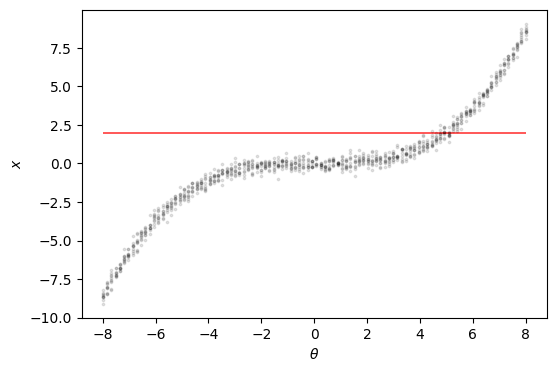

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))

for theta in np.linspace(-8, 8, 100):
    x = gaussian_simulator(theta, n=10)
    ax.scatter(theta.repeat(len(x)), x, c='black', alpha=.1, s=3)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$x$')

    plt.plot([-8, 8],[2, 2], color='red', linewidth=.1, alpha=.1)

plt.show()

In [4]:
''' 
Create a simple density estimator -- in this case, a simple MLP 
that maps out parameters \theta to a Gaussian distribution over 
the loss is then the negative log likleihood of N(f(theta)) at x
'''
class Emulator(nn.Module):
    ''' Architecture configuration from Lueckmann 
        - output parameterize mean and covariance
        - hidden layer of 10 tanh units
    '''
    def __init__(self, theta_dim=1, hidden_dim=10):
        super(Emulator, self).__init__()
        self.hidden = nn.Linear(theta_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = F.tanh(self.hidden(x)) 
        output = self.output(x)
        if len(x.shape) > 1:
            mean, var = output[:,0], output[:,1]
        else:
            mean, var = output[0], output[1]
        dist = Normal(mean, F.relu(var)+.0001)
        return dist
        
        
def train_network(train_dataloader, valid_dataloader, lr=0.01, epochs=100, validation_rate=5, verbose=True):
    ''' Training description from Lueckmann
        - Adam optimizer (beta_1 = .9, beta_2 = .999)
        - hidden layer with 10 tanh units
        - learning rate = 0.01
    '''
    emulator = Emulator()
    optimizer = th.optim.Adam(emulator.parameters(), lr=lr)
    avg_train_losses = []
    avg_valid_losses = []
    for epoch in range(1, epochs+1):        
        train_loss = []
        for theta, x in train_dataloader:
            loss = -emulator(theta).log_prob(x).mean()
            loss.backward()
            optimizer.step()aasdfas;ldfkhfhfh
            optimizer.zero_grad()
            train_loss.append(loss.detach())
            # should add a validation loop for early stopping
        train_loss = th.stack(train_loss)
        avg_train_loss, std_train_loss = train_loss.mean().item(), train_loss.std().item()
        avg_train_losses.append(avg_train_loss)
        
        if epoch % validation_rate == 0:
            # i guess i dont even need to batch 
            with th.no_grad():
                valid_loss = []
                for theta, x in valid_dataloader:
                    loss = -emulator(theta).log_prob(x).mean()
                    valid_loss.append(loss)
                valid_loss = th.stack(valid_loss)
                avg_valid_loss, std_valid_loss = valid_loss.mean().item(), valid_loss.std().item()
                avg_valid_losses.append(avg_valid_loss)
        if epoch % 50 == 0 and verbose:
            print(f"({epoch}): {avg_train_loss:.3f}, {avg_valid_loss:.3f}")
        
    return emulator, avg_train_losses, avg_valid_losses

In [5]:
# sample initial dataset
x_obs = np.array([2])
prior = Uniform(-8, 8)

# construct training set 
train_size = 10000
theta_init_train = th.Tensor(prior.sample(sample_shape=(train_size,)))
x_init_train = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_train]).squeeze())
trainset = data.TensorDataset(theta_init_train.unsqueeze(-1), x_init_train)
trainloader = data.DataLoader(trainset, batch_size=50, shuffle=True)

# construct validation set 
valid_size = 1000
theta_init_valid = th.Tensor(prior.sample(sample_shape=(valid_size,)))
x_init_valid = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_valid]).squeeze())
validset = data.TensorDataset(theta_init_valid.unsqueeze(-1), x_init_valid)
validloader = data.DataLoader(validset, batch_size=5, shuffle=True)


# number of samples 10000
# batch size 100
# epochs 500
# it seems like batch size should be 1/5 number of epochs
n_epochs = 250
valid_rate = 1
net, train_loss, valid_loss = train_network(trainloader, validloader, epochs=n_epochs, validation_rate=valid_rate, verbose=True)

(50): 8.612, 8.505
(100): 2.600, 2.554
(150): 1.044, 0.979
(200): 0.264, 0.299
(250): 0.264, 0.330


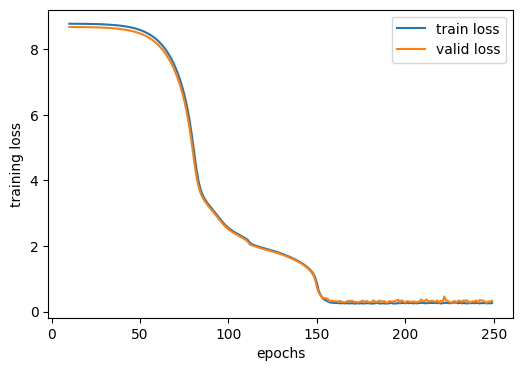

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(np.arange(0, n_epochs)[10:], train_loss[10:], label='train loss')
ax.plot(np.arange(0, n_epochs)[10:], valid_loss[10:], label='valid loss')

ax.set_xlabel('epochs')
ax.set_ylabel('training loss')

plt.legend()
plt.show()

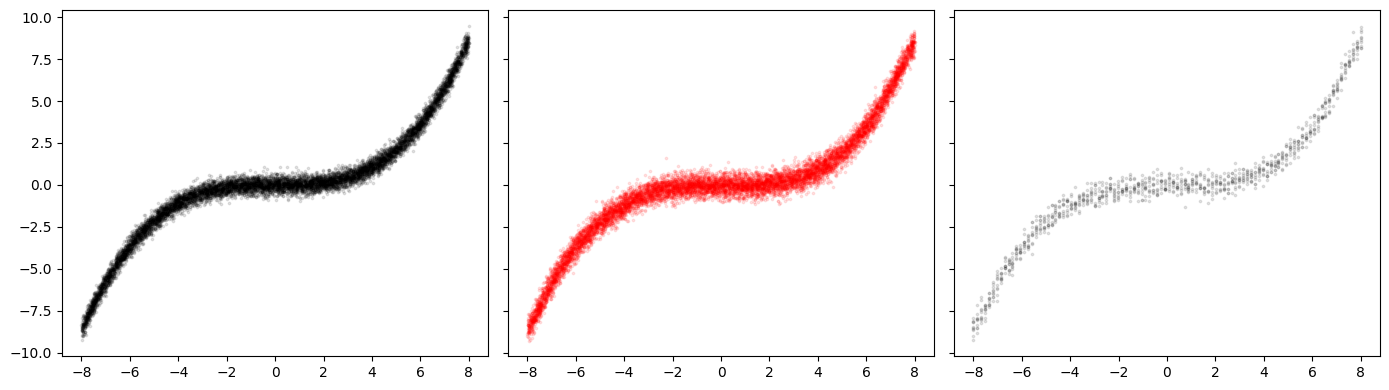

In [10]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=3, sharex=True, sharey=True)
ax[0].scatter(theta_init_train, x_init_train, c='black', alpha=.1, s=3)

predictions=[]
for theta in theta_init_train:
    x_pred = net(theta.unsqueeze(-1)).sample()
    predictions.append(x_pred)

ax[1].scatter(theta_init_train, predictions, c='red', alpha=.1, s=3)

n_samples = 10 
for theta in th.linspace(-8, 8, 100):
    dist = net(theta.unsqueeze(-1))
    samples = dist.sample((n_samples,))
    ax[2].scatter(theta.repeat(n_samples), samples, c='black', alpha=.1, s=3)

plt.tight_layout()
plt.show()

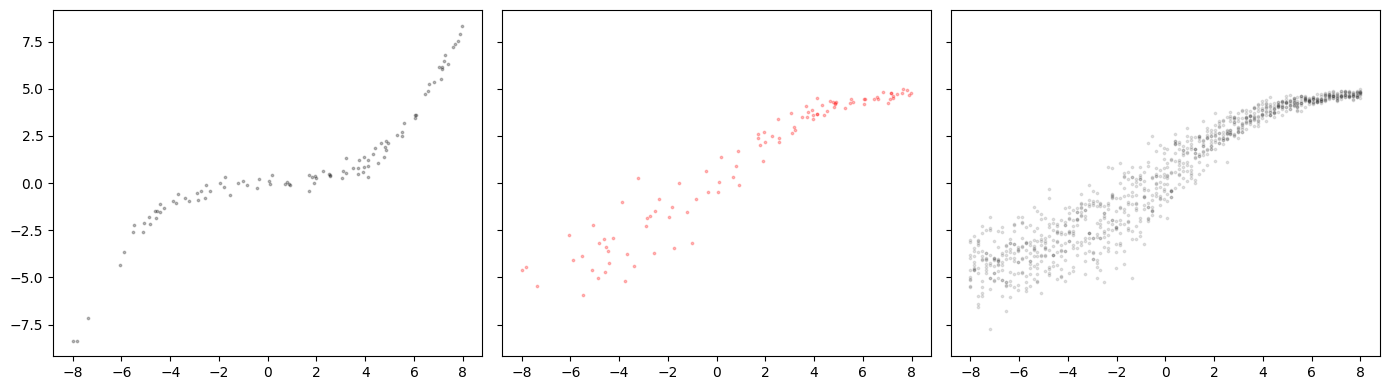

In [15]:
# sample initial dataset
x_obs = np.array([2])
prior = Uniform(-8, 8)

# construct training set 
train_size = 100
theta_init_train = th.Tensor(prior.sample(sample_shape=(train_size,)))
x_init_train = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_train]).squeeze())
trainset = data.TensorDataset(theta_init_train.unsqueeze(-1), x_init_train)
trainloader = data.DataLoader(trainset, batch_size=50, shuffle=True)

# construct validation set 
valid_size = 10
theta_init_valid = th.Tensor(prior.sample(sample_shape=(valid_size,)))
x_init_valid = th.Tensor(np.array([gaussian_simulator(t) for t in theta_init_valid]).squeeze())
validset = data.TensorDataset(theta_init_valid.unsqueeze(-1), x_init_valid)
validloader = data.DataLoader(validset, batch_size=5, shuffle=True)


# number of samples 10000
# batch size 100
# epochs 500
# it seems like batch size should be 1/5 number of epochs
n_epochs = 550
net, train_loss, valid_loss = train_network(trainloader, validloader, epochs=n_epochs, validation_rate=1, verbose=False)

fig, ax = plt.subplots(figsize=(14, 4), ncols=3, sharex=True, sharey=True)
ax[0].scatter(theta_init_train, x_init_train, c='black', alpha=.25, s=3)

predictions=[]
for theta in theta_init_train:
    x_pred = net(theta.unsqueeze(-1)).sample()
    predictions.append(x_pred)

ax[1].scatter(theta_init_train, predictions, c='red', alpha=.25, s=3)

n_samples = 10 
for theta in th.linspace(-8, 8, 100):
    dist = net(theta.unsqueeze(-1))
    samples = dist.sample((n_samples,))
    ax[2].scatter(theta.repeat(n_samples), samples, c='black', alpha=.1, s=3)

plt.tight_layout()
plt.show()

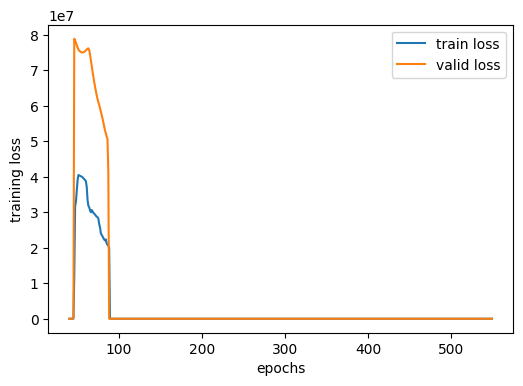

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

t = 40
ax.plot(np.arange(0, n_epochs)[t:], train_loss[t:], label='train loss')
ax.plot(np.arange(0, n_epochs)[t:], valid_loss[t:], label='valid loss')

ax.set_xlabel('epochs')
ax.set_ylabel('training loss')

plt.legend()
plt.show()

In [12]:
def create_dataloader(theta, x, batch_size=1):
    trainset = data.TensorDataset(theta.unsqueeze(-1), x)
    dataloader = data.DataLoader(trainset, batch_size=2, shuffle=True)
    return dataloader

In [13]:
# define obs & prior
x_obs = th.Tensor([2])
prior = Uniform(-8, 8)

# sample initial dataset
init_dataset_size = 50 
theta_train = th.Tensor(prior.sample(sample_shape=(init_dataset_size,)))
x_train = th.Tensor(np.array([gaussian_simulator(t) for t in theta_train]).squeeze())

## training configuration
n_rounds = 10
n_samples = 15
n_emulators = 10
batch_size = 5
n_epochs = 500

## training loop 
all_likelihoods = []
for _ in trange(n_rounds):
    # train ensembles
    ensemble, likelihood_matrix = [], []
    trainloader = create_dataloader(theta_train, x_train, batch_size=batch_size)
    for _ in range(n_emulators):
        ## do we want to retrain the entire newtork??
        network,_ = train_network(trainloader, epochs=n_epochs, verbose=False)
        ## do we want to use theta_train here??
        probs = network(theta_train.unsqueeze(-1)).log_prob(x_obs)
        ensemble.append(network)
        likelihood_matrix.append(probs.detach().numpy())
    
    likelihood_matrix = np.array(likelihood_matrix)
    index = np.argmax(likelihood_matrix.var(axis=0))
    theta_new = theta_train[index]
    x_new = th.Tensor(np.array([gaussian_simulator(theta_new, n=n_samples)]).squeeze())
    x_train = th.concat([x_train, x_new])
    theta_train = th.concat([theta_train, theta_new.repeat(n_samples)])
    all_likelihoods.append(likelihood_matrix)


  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
x_pred = np.array([net(theta.unsqueeze(-1)).sample() for net in ensemble])
x_pred

array([], dtype=float64)

/var/folders/f3/d5xwhmfs3tz1mx_rvf_24qb80000gn/T/ipykernel_93170/3614149716.py:6: RuntimeWarning: Mean of empty slice.
  x_pred = np.array([net(theta.unsqueeze(-1)).sample() for net in ensemble]).mean()
/Users/hayden/Desktop/code/research/goncalves-lab/emulator-networks/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


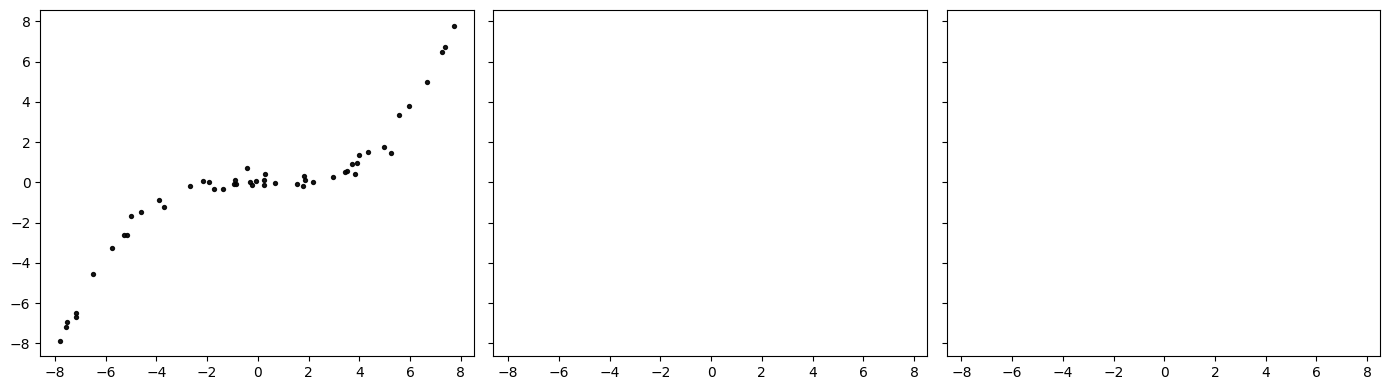

In [33]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=3, sharex=True, sharey=True)
ax[0].scatter(theta_train, x_train, c='black', alpha=.9, s=8)

predictions=[]
for theta in theta_train:
    x_pred = np.array([net(theta.unsqueeze(-1)).sample() for net in ensemble]).mean()
    predictions.append(x_pred)

ax[1].scatter(theta_train, predictions, c='red', alpha=.9, s=8)

#n_samples = 10 
#for theta in th.linspace(-8, 8, 100):
#    dist = net(theta.unsqueeze(-1))
#    samples = dist.sample((n_samples,))
#    ax[2].scatter(theta.repeat(n_samples), samples, c='black', alpha=.1, s=3)

plt.tight_layout()
plt.show()

In [ ]:
theta_train[50:]

tensor([-7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458, -7.8458,
        -7.8458, -7.8458, -7.8458, -7.84

In [105]:
theta_train

tensor([ 1.0599,  3.5632, -3.1460, -2.7165, -3.8464,  6.5631, -0.5379, -7.2056,
        -2.4019, -4.9219, -0.6433, -6.5773,  2.7297, -7.2965, -3.3913,  3.7260,
         6.5631,  6.5631,  6.5631,  6.5631,  6.5631, -7.2965, -7.2965, -7.2965,
        -7.2965, -7.2965, -7.2965, -7.2965, -7.2965, -7.2965, -7.2965])

In [73]:
x_init.shape

torch.Size([100])

In [62]:
likelihood_matrix

array([[ -2.1299834 ,  -0.8473271 ,  -1.6636041 , -14.576711  ,
         -1.709496  ],
       [ -1.523133  ,  -1.0736566 ,  -1.2696104 ,  -8.71239   ,
         -1.4741366 ],
       [ -1.8646313 ,  -3.7948413 ,  -6.100678  , -14.803821  ,
         -1.0899975 ],
       [ -6.2606826 ,  -3.3634796 ,  -1.6947815 ,  -5.5951557 ,
         -5.780322  ],
       [-22.690918  ,  -1.1508148 ,  -2.524095  , -14.456966  ,
         -8.928452  ],
       [ -2.4616642 ,  -2.284924  ,  -2.22599   ,  -1.859093  ,
         -2.4086308 ],
       [ -5.002359  ,  -7.778093  , -10.236049  , -51.697     ,
         -5.685643  ],
       [ -5.2496805 ,  -0.77612054,  -3.3935266 , -13.831925  ,
         -3.4534955 ],
       [ -1.1756358 ,  -1.0126405 ,  -1.7089267 , -12.29371   ,
         -1.0899364 ],
       [ -1.5615206 ,  -1.7569649 ,  -2.1790757 ,  -4.1942816 ,
         -1.6126667 ]], dtype=float32)

<Axes: >

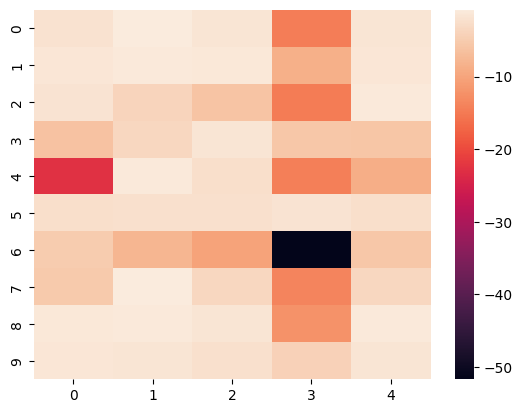

In [65]:
import seaborn as sns

sns.heatmap(likelihood_matrix)

In [24]:
index = np.argmax(likelihood_matrix.var(axis=0))
theta[index]

tensor(-4.7380)